In [89]:
import pandas as pd
import seaborn as sea
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

## Lendo csv's

In [149]:
BH = pd.read_csv("D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELOHORIZONTE_83587_H_2000-01-01_2019-12-31.csv", sep = ";")
UB = pd.read_csv("D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_UBERLANDIA_A507_H_2002-12-17_2019-12-31.csv", sep = ";")
BM = pd.read_csv("D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELEM_A201_H_2003-01-19_2019-12-31.csv", sep = ";")
QX = pd.read_csv("D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_QUIXERAMOBIM_A325_H_2007-07-08_2019-12-31.csv", sep = ";")
TM = pd.read_csv("D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_TRESMARIAS_A528_H_2006-08-24_2019-12-31.csv", sep = ";")
df_list = ['Belo Horizonte', 'Uberlândia', 'Belém', 'Quixeramobim', 'Três Marias']

In [3]:
def sepYear(data):
    corte = data[-4:]
    return int(corte)

def sepMonth(data):
    corte = data[3:5]
    return int(corte)

def sepDay(data):
    corte = data[:2]
    return int(corte)

def virgPont(data):
    subs = data.replace(',','.')
    return subs

## Criando colunas de dia - mês - ano

In [20]:
def cols_DMA(usina):
    usina['year'] = usina['Data Medicao'].apply(sepYear)
    usina['month'] = usina['Data Medicao'].apply(sepMonth)
    usina['day'] = usina['Data Medicao'].apply(sepDay)
    return usina

## Deletando anos menores que 2010

In [21]:
def csv_adapt(usina):
    usina = cols_DMA(usina)
    usina = usina.where(usina['year']>=2010).dropna()
    usina['VENTO, VELOCIDADE HORARIA(m/s)'] = usina['VENTO, VELOCIDADE HORARIA(m/s)'].apply(virgPont)
    usina['u10'] = pd.to_numeric(usina['VENTO, VELOCIDADE HORARIA(m/s)'])
    usina = usina.drop(columns=['VENTO, VELOCIDADE HORARIA(m/s)'])
    return usina

In [22]:
csv_adapt(BH)

,Data Medicao,Hora Medicao,year,month,day,u10
10959,01/01/2010,0.0,2010.0,1.0,1.0,1.6
10960,01/01/2010,1200.0,2010.0,1.0,1.0,3.0
10961,01/01/2010,1800.0,2010.0,1.0,1.0,2.6
10962,02/01/2010,0.0,2010.0,1.0,2.0,2.1
10963,02/01/2010,1200.0,2010.0,1.0,2.0,2.1
...,...,...,...,...,...,...
21910,30/12/2019,1200.0,2019.0,12.0,30.0,1.1
21911,30/12/2019,1800.0,2019.0,12.0,30.0,1.5
21912,31/12/2019,0.0,2019.0,12.0,31.0,1.3
21913,31/12/2019,1200.0,2019.0,12.0,31.0,1.6


In [101]:
def media_turno(usina, turno, z0):
    # Faz a média dependendo do turno escolhido e retorna 2 objetos: o DataFrame de média mensal pro turno
    #                                                              e o valor de uTAL numa variável
    usina = csv_adapt(usina)
    
    if turno == 'diurno':
        usina = usina.where((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media
    
    if turno == 'noturno':
        usina = usina.mask((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media

In [147]:
def calc_u130(usina, turno):
    # Essa função por si só já chama todas as outras necessárias para o cálculo da média u130 e retorna um DataFrame com os meses no index
    
    if usina == 'Belo Horizonte':
        z0 = 3
        media = media_turno(BH, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
    elif usina == 'Uberlândia':
        z0 = 2
        media = media_turno(UB, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
    elif usina == 'Belém':
        z0 = 2
        media = media_turno(BM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
    elif usina == 'Quixeramobim':
        z0 = 0.02
        media = media_turno(QX, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
    elif usina == 'Três Marias':
        z0 = 0.1
        media = media_turno(TM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
    else:
        warnings.warn('please inform the usin so z0 value can be determined')
    return media

In [115]:
mediaD_Quixeramobim_u130 = calc_u130('QX', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Quixeramobim_u130.csv')
mediaN_Quixeramobim_u130 = calc_u130('QX', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Quixeramobim_u130.csv')

mediaD_BeloHorizonte_u130 = calc_u130('BH', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_BeloHorizonte_u130.csv')
mediaN_BeloHorizonte_u130 = calc_u130('BH', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_BeloHorizonte_u130.csv')

mediaD_Uberlandia_u130 = calc_u130('UB', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Uberlandia_u130.csv')
mediaN_Uberlandia_u130 = calc_u130('UB', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Uberlandia_u130.csv')

mediaD_Belem_u130 = calc_u130('BM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Belem_u130.csv')
mediaN_Belem_u130 = calc_u130('BM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Belem_u130.csv')

mediaD_TresMarias_u130 = calc_u130('TM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_TresMarias_u130.csv')
mediaN_TresMarias_u130 = calc_u130('TM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_TresMarias_u130.csv')


<AxesSubplot:xlabel='month', ylabel='u130'>

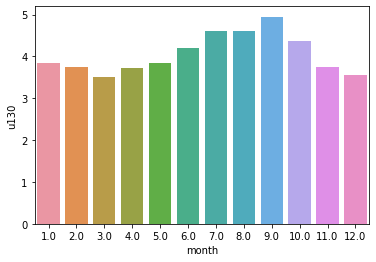

In [137]:
sea.barplot(calc_u130('TM', 'diurno').index, calc_u130('TM', 'diurno')['u130'])

In [162]:
def plot_bar(usina, turno):
    
    mediaF = calc_u130(usina, turno)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,7))

    sea.set_style('darkgrid')
    sea.barplot(x = mediaF.index, y = mediaF['u130'], orient='v', palette = 'Blues_d')

    ax.set_title('Média Mensal de u130 '+ turno + ' em ' + usina , size = 20, pad = 9)
    ax.set_xlabel('Mês', fontdict={'fontsize': 15})
    ax.set_ylabel('Magnitude do Vento em m/s', fontdict={'fontsize': 13})
    plt.savefig('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/images/bars/u130_' + usina + '_' + turno + '.jpg')

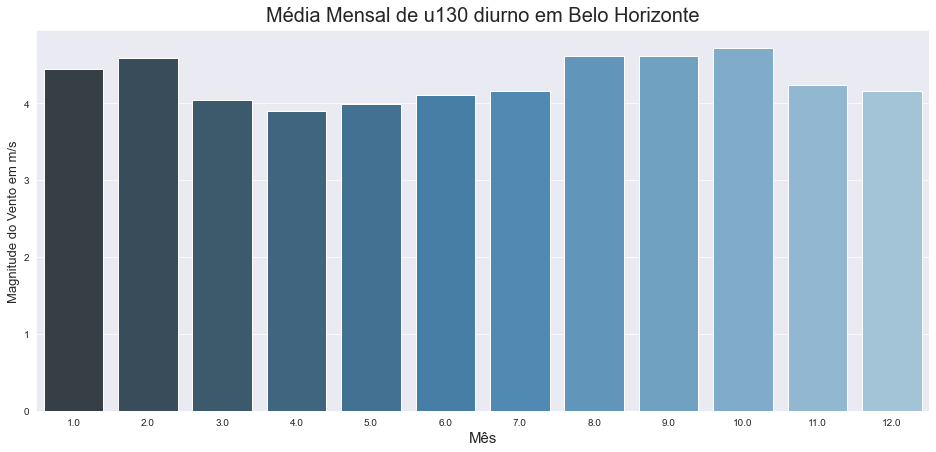

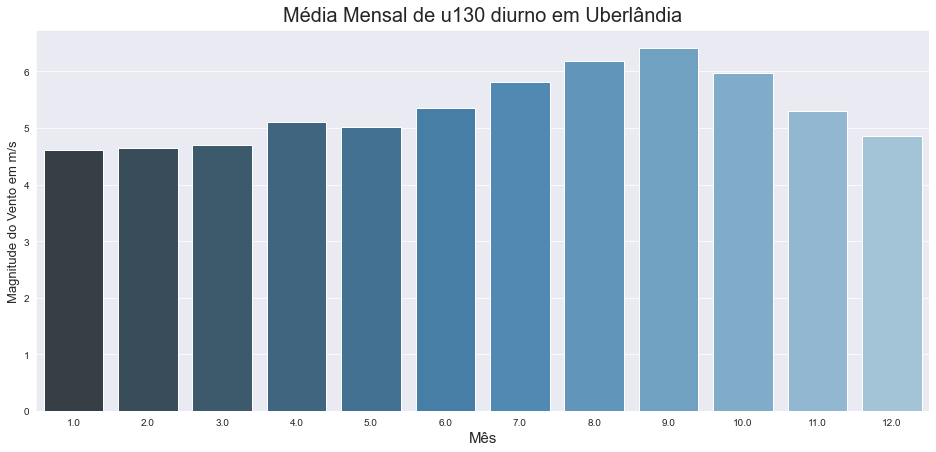

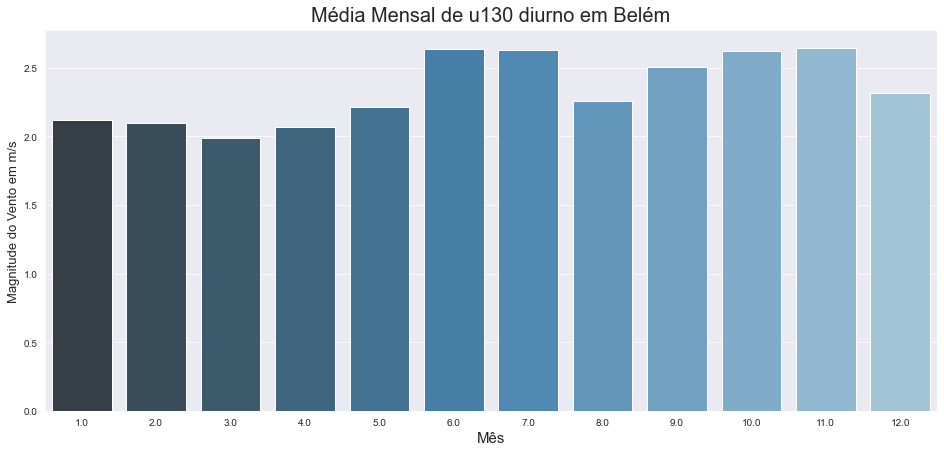

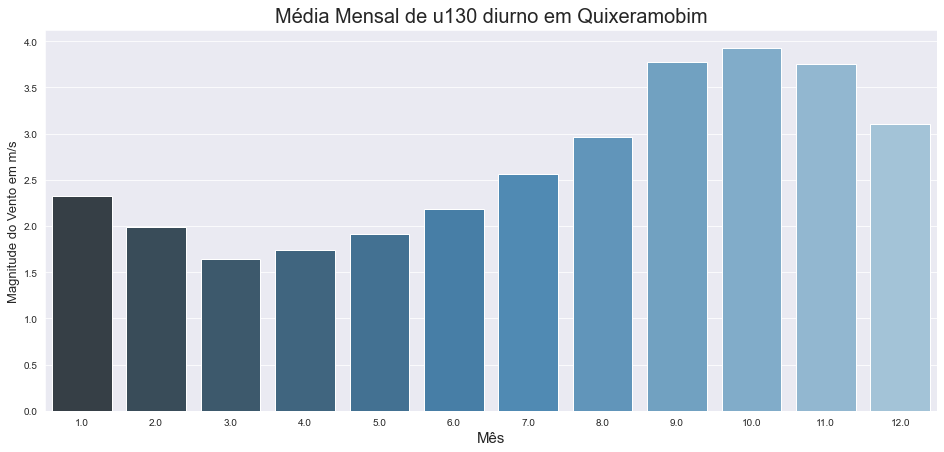

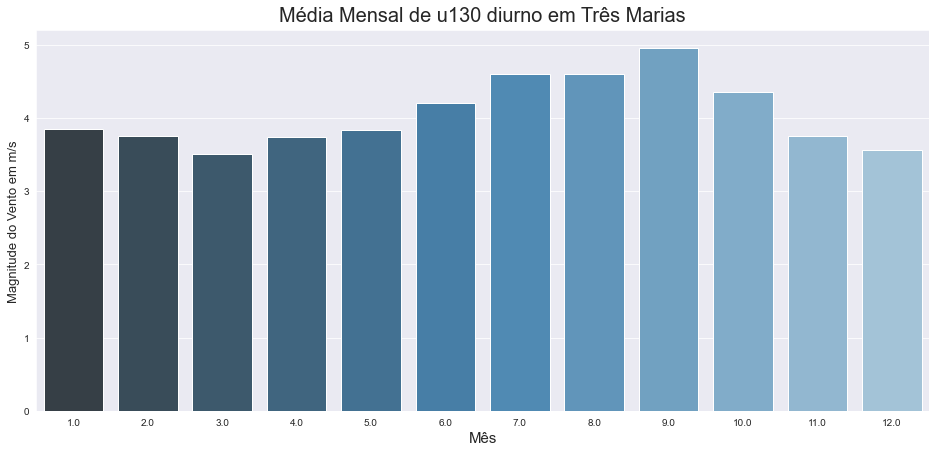

In [163]:
for cada in df_list:
    plot_bar(cada, 'diurno')

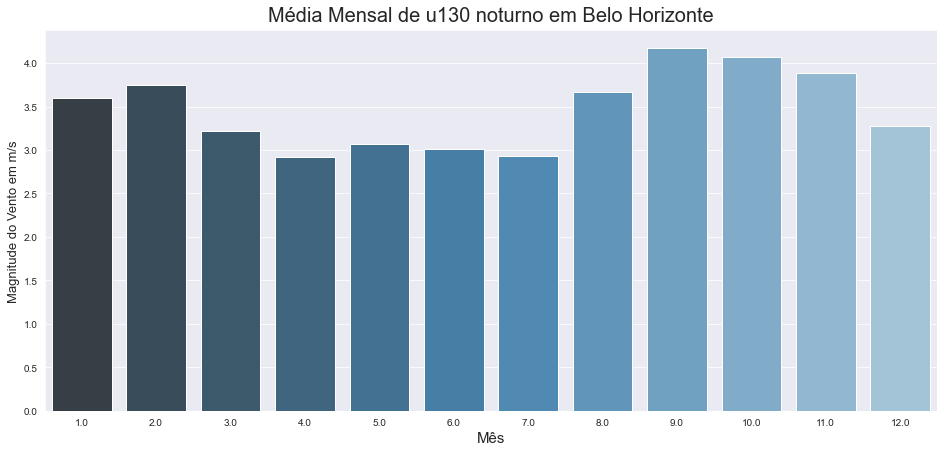

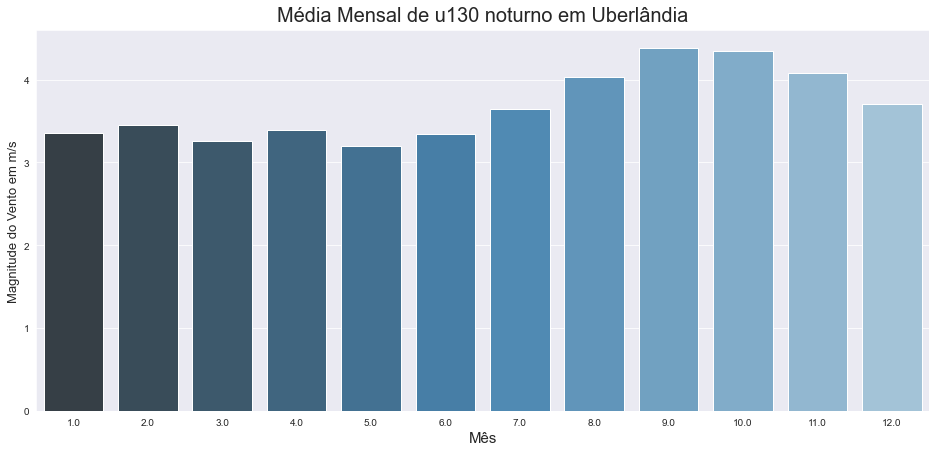

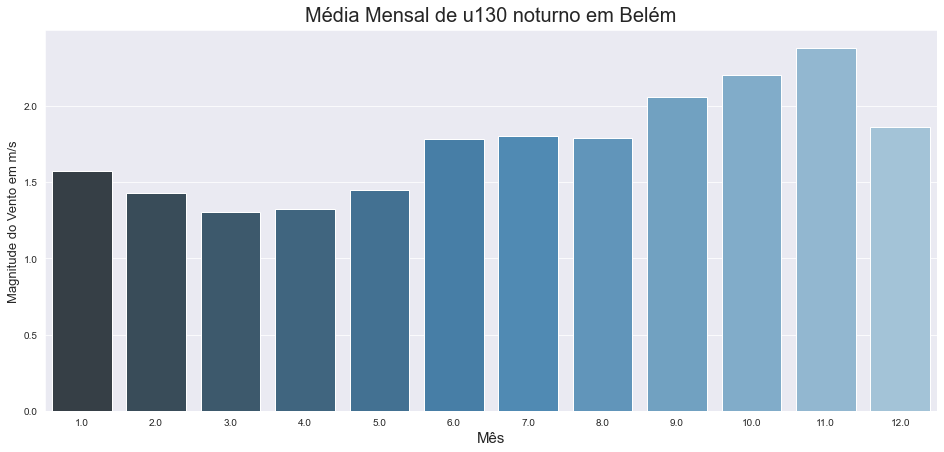

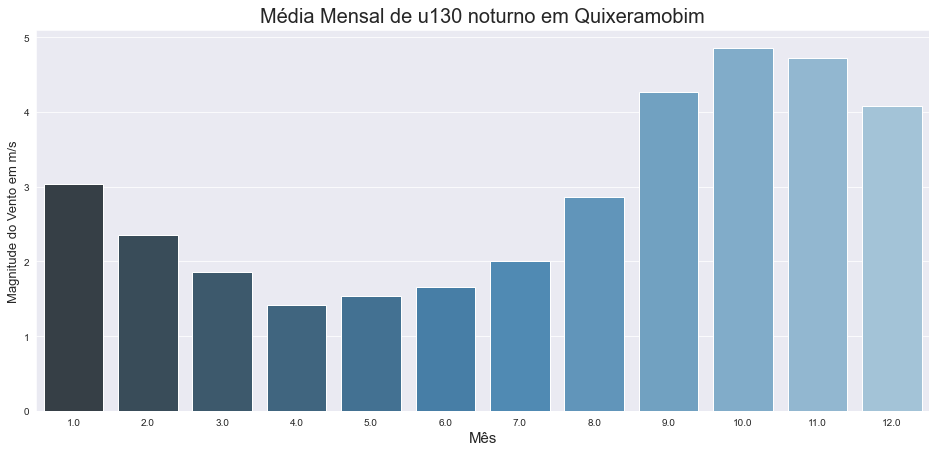

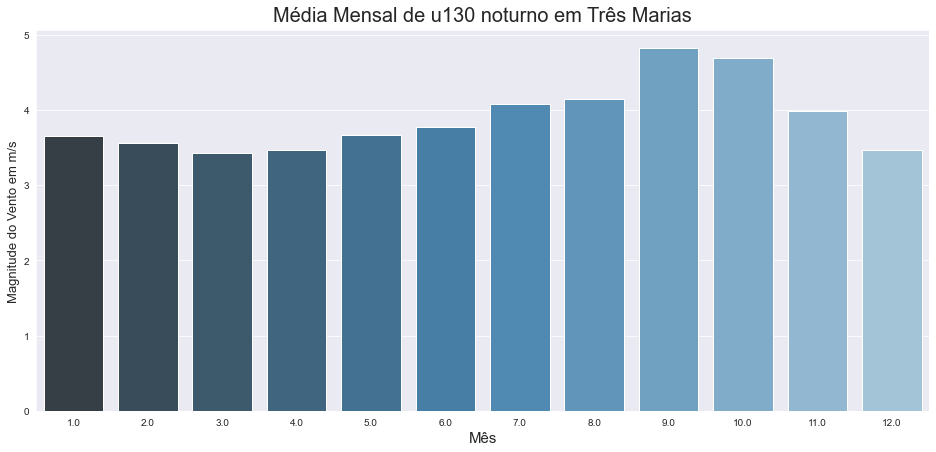

In [164]:
for cada in df_list:
    plot_bar(cada, 'noturno')